<a href="https://colab.research.google.com/github/stratoskar/Path-Based-Traffic-Flow-Prediction/blob/main/Python_Code/Data_Exploration_and_Time_Series_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Dataframe libraries
import numpy as np
import polars as pl
import pandas as pd

# Import libraries to draw graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Library to cast datetime data
from datetime import timedelta

# Import random module
import random

# Access google drive files
from google.colab import drive

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Access google drive location
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read dataframe with the data
all_data = pl.read_csv('/content/drive/MyDrive/Paper/Map_Matched_Data/mmdata_new.csv',try_parse_dates=True)

In this research, we assume that **the road network is hybrid graph G = (V,E)** with simple and directed edges.

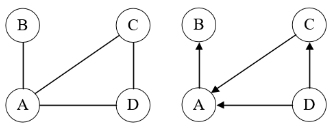

In this graph, V is the **set of vertices** and E is the **set of Edges**.

Each vertice in the graph represents an intersection of the road network, while each edge represents a road segment between two intersections.

**From now on, we define as edge every road segment.**

In [ ]:
# Sort values in dataframe
all_data = all_data.sort(['taxi_id','traj_id','expected_start_time','expected_end_time'])

In [ ]:
# Check if there are duplicate values in the dataset
print(f'Dataframe shape before drop duplicate rows: {all_data.shape}')
print(f'Dataframe shape after drop duplicate rows: {all_data.unique().shape}')

Dataframe shape before drop duplicate rows: (67143876, 8)
Dataframe shape after drop duplicate rows: (67143876, 8)


Based on the output above, there are no duplicate rows in the dataset.

In [ ]:
# Print first 5 rows of the dataset
all_data.head(5)

taxi_id,traj_id,osm_way_id,edge_length,edge_speed,road_class,expected_start_time,expected_end_time
i64,i64,i64,f64,i64,str,datetime[μs],datetime[μs]
0,0,48582250,0.266,89,"""motorway""",2008-05-17 10:00:29,2008-05-17 10:00:35.246575
0,0,513702094,0.063,89,"""motorway""",2008-05-17 10:00:35.246575,2008-05-17 10:00:41.493150
0,0,513702093,0.12,89,"""motorway""",2008-05-17 10:00:41.493150,2008-05-17 10:00:47.739725
0,0,23925280,0.077,89,"""motorway""",2008-05-17 10:00:47.739725,2008-05-17 10:00:53.986300
0,0,27652284,0.224,89,"""motorway""",2008-05-17 10:00:53.986300,2008-05-17 10:01:00.232875


**There are several columns inside the dataset. Each column stores a specific information.**

**taxi_id** and **traj_id** columns define together a trajectory of a
taxi.

**osm_way_id** column contains the edges that a specific trajecotry crossed.
**edge_length** column contains information about the length (in Km) of the specific edge.

**edge_speed** column contains information about the maximum speed limit inside this specific edge.

**road_class** column contains information about the type of this edge.

**expected_start_time** and **expected_end_time** share information about what time a taxi inserted and exited a specific edge.





In [4]:
# Convert polars dataframe into a pandas dataframe
all_data = all_data.to_pandas()

In [ ]:
# Show what type (and how many) of edges are present in the dataset
all_data['road_class'].value_counts()

secondary        24621936
tertiary         16163133
primary           9184945
residential       7500987
motorway          4418504
trunk             2246185
service_other     1793331
unclassified      1214855
Name: road_class, dtype: int64

In [6]:
# How many trajectories are present in the dataset?
number_of_trajectories = all_data.loc[:, ['taxi_id', 'traj_id']].drop_duplicates().shape[0]
print(f'There are {number_of_trajectories} trajectories present in the dataset.')

There are 521135 present in the dataset.


There are meny edges of type '**secondary**' in the dataset.
Also, there are many edges that are considered **unclassified**.
This column gives us valueable information, but not the full truth
about the edge types.

In [ ]:
# Delete trajectories, which contain only one OSM Way ID record, and thus they are useless for our research
uniques = all_data.loc[:, ['taxi_id', 'traj_id']].drop_duplicates(keep=False).index
all_data.drop(uniques,axis=0,inplace=True)
all_data.reset_index(drop=True,inplace=True)
all_data = all_data.sort_values(['taxi_id','traj_id','expected_start_time', 'expected_end_time']).reset_index(drop=True)

In [ ]:
# Print the shape of the dataset after deleting trajectories with only one record
print(f'The shape of the dataset after deletion is: {all_data.shape}')

The shape of the dataset after deletion is: (67143876, 8)


In [ ]:
# Check if there are missing values in the dataset
all_data.isna().sum()

taxi_id                0
traj_id                0
osm_way_id             0
edge_length            0
edge_speed             0
road_class             0
expected_start_time    0
expected_end_time      0
dtype: int64

There are no missing values in the dataset.

In [ ]:
# Show data types in the dataset
all_data.dtypes

taxi_id                         int64
traj_id                         int64
osm_way_id                      int64
edge_length                   float64
edge_speed                      int64
road_class                     object
expected_start_time    datetime64[ns]
expected_end_time      datetime64[ns]
dtype: object

In [ ]:
# Find max and min timestamp that is present in the dataset
min_timestamp = all_data['expected_start_time'].min()
print("Min timestamp value that is present in the dataset is: ",min_timestamp)

max_timestamp = all_data['expected_end_time'].max()
print("Max timestamp value that is present in the dataset is: ",max_timestamp)

# Calculate total seconds between max and min value
total_sec = (max_timestamp-min_timestamp).total_seconds()
print(f"\nTotal duration of the recordings in this dataset is {total_sec/3600} hours")

Min timestamp value that is present in the dataset is:  2008-05-17 10:00:04
Max timestamp value that is present in the dataset is:  2008-06-10 09:22:06.000006

Total duration of the recordings in this dataset is 575.3672222238889 hours


In [ ]:
# This list contains the time intervals that will be used for the time series data
# Each time interval has a duration of 30 minutes.
time_info = []
i =0
while(True):
    if i == 0:
        time_info.append(min_timestamp)
    else:
        time_info.append(time_info[i-1] + timedelta(seconds=1800))

    if (time_info[i]>=max_timestamp):
        break

    i+=1

# Create pairs of consecutive values of the list time_info
time_intervals = list(zip(*[time_info[i:] for i in range(2)]))

In [ ]:
# Print the generated time intervals
time_intervals

[(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04')),
 (Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04')),
 (Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04')),
 (Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04')),
 (Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04')),
 (Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04')),
 (Timestamp('2008-05-17 13:00:04'), Timestamp('2008-05-17 13:30:04')),
 (Timestamp('2008-05-17 13:30:04'), Timestamp('2008-05-17 14:00:04')),
 (Timestamp('2008-05-17 14:00:04'), Timestamp('2008-05-17 14:30:04')),
 (Timestamp('2008-05-17 14:30:04'), Timestamp('2008-05-17 15:00:04')),
 (Timestamp('2008-05-17 15:00:04'), Timestamp('2008-05-17 15:30:04')),
 (Timestamp('2008-05-17 15:30:04'), Timestamp('2008-05-17 16:00:04')),
 (Timestamp('2008-05-17 16:00:04'), Timestamp('2008-05-17 16:30:04')),
 (Timestamp('2008-05-17 16:30:04'), Timestamp('2008-05-17 17:00:04')),
 (Time

**Generate random unique paths of random lengths**

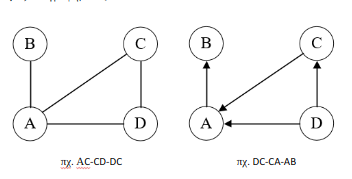

Assuming that we have a road network represented as a graph G=(V,E), as presented in the image above. A path is a set of 2 or more concequtive edges e, so that e belongs to set E. For example, a path AC -> CD -> DC is a legal path, according to this definition.

In this research, each path can be of any length between 2 and 15. The number of consecutive edges contained in the path defines it's length. The code below uses the dataset's data to generate the unique paths.

In [ ]:
# Empty dataframe, in which all the unique paths will be saved
paths = pd.DataFrame(columns=['taxi_id','traj_id','path','length'])

# Define the length options
length_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# This list is used, in order to be sure that paths created are unique
check = []

# Legal indexes in which algorithm can search for paths
indexes = np.arange(all_data.shape[0]-max(length_options)+1)

i = 0

# Number of paths to be created
n = 1000

while (paths.shape[0] < n):
    # This list will save the path created
    p = []

    # Select randomly an index
    selected_index = random.choice(indexes)

    # The length of the new path to be created
    selected_length = random.choice(length_options)

    # check if path is within the same trajectory
    if ((all_data.at[selected_index,'taxi_id'] == all_data.at[selected_index+(selected_length-1),'taxi_id']) &
        (all_data.at[selected_index,'traj_id'] == all_data.at[selected_index+(selected_length-1),'traj_id'])):

        # Iterate to the data and extract the consequtive
        # [selected_index...index+selected_length] osm_way_ids
        for y in range(selected_length):
            p.append(int(all_data.at[selected_index+y,'osm_way_id']))

        # If path is unique, then add it to paths dataframe
        if p not in check:
            check.append(p)

            paths.at[i,'taxi_id'] = all_data.at[selected_index,'taxi_id']
            paths.at[i,'traj_id'] = all_data.at[selected_index,'traj_id']

            # Add the new path to the dataframe
            paths.at[i,'path'] = p
            paths.at[i,'length'] = selected_length
            i += 1
        else:
            continue

In [ ]:
# Print the dataframe that contains the generated paths
paths

,taxi_id,traj_id,path,length
0,320,1167,"[112470382, 112470382, 112470382, 112470382]",4
1,72,874,"[769473273, 769473273]",2
2,389,569,"[771410424, 771410424]",2
3,168,1073,"[12437582, 12437582, 12437582, 12437582, 12437...",5
4,396,1059,"[254759959, 254759959, 254759959, 417389562, 4...",10
...,...,...,...,...
995,196,91,"[86331227, 133856219, 133856219]",3
996,505,455,"[397146706, 254466686, 254466686, 417099330, 4...",10
997,440,1288,"[525564024, 680402684, 680402683]",3
998,147,102,"[515611953, 396959904, 396959900, 396959900, 3...",10


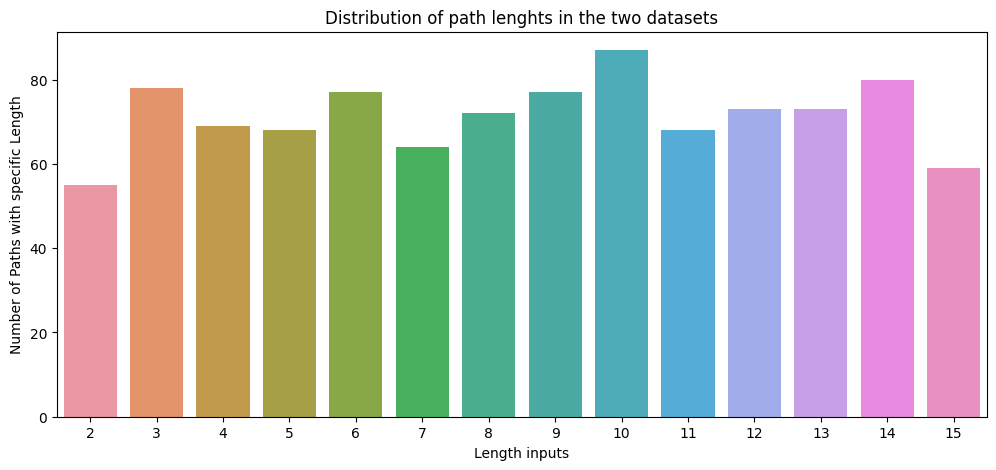

In [ ]:
# Count the number of paths grouped by length attribute
plt.figure(figsize=(12,5))
sns.countplot(paths,x='length')
plt.xlabel('Length inputs')
plt.ylabel('Number of Paths with specific Length')
plt.title('Distribution of path lenghts in the two datasets')
plt.show()

Based on the graph above, we observe that there is a uniform distribution of paths lengths in the generated paths.

**Create the SPQ function**

In [ ]:
def SPQ(path,time_enter,time_leave):
  '''
  The SPQ (Strict Path Query) function, returns all the trajectories that pass through given path of edges at a given time interval.

  Parameters:
    path: The path that the trajectories should exactly follow (edge by edge - one by one).
    time_enter: The time, in which the trajectory should enter the first edge of the path given as input.
    time_leave: The time, in which the trajectory should leave the last edge of the path given as input.

  Returns:
    1) The numbers of trajectories that passed through this path at the given time interval.
    2) The sum of time that every vehicle needed to cross the whole path.
  '''
  # Length of the path given to the function
  path_length = len(path)

  # For each trajectory that meets the criteria, compute the time interval needed for the path to be crossed.
  # For each trajectory, save this number in a list
  time_intervals = []

  # This list will save temporarily the trajectories that match the SPQ condition
  trajectories = []

  # Find all the indexes, in which the first edge in the path is located
  needed_indexes = examined_data[examined_data['osm_way_id'] == path[0]].index

  # Iterate through all indexes
  for index in needed_indexes:
      traj_id = examined_data.at[index,'traj_id'] # Store the trajectory id
      taxi_id = examined_data.at[index,'taxi_id'] # Store the taxi id
      st_time = examined_data.at[index,'expected_start_time'] # Store the start time
      inter = 1

      # Decide if the row in the next index matches the criteria (same Taxi_ID, same Traj_ID, the path required)
      for i in range(1,path_length):
          try:
              if (not ((examined_data['osm_way_id'].iloc[index+i] == path[i])
                        & (examined_data['traj_id'].iloc[index+i] == traj_id)
                      & (examined_data['taxi_id'].iloc[index+i] == taxi_id))):

                  break

              inter += 1 # If the criteria match, then increase inter counter by one
              en_time = examined_data['expected_end_time'].iloc[index+1] # Store the end time

          except:
              pass # Index out of bounds exception (do nothing)

      # If the criteria match as many times as the length of the path, then we found one trajectory
      if (path_length == inter):
          trajectories.append((taxi_id,traj_id)) # Add this trajectory to the trajectories list
          time_intervals.append((en_time-st_time).seconds)

  # Return the number of trajectories that matches the criteria
  return ((len([t for t in (set(tuple(i) for i in trajectories))])), sum(time_intervals))

In [ ]:
# Create an empty dataframe to store SPQ timeseries (number of taxis that crossed a path at a certain time interval)
traffic_flow_SPQ = pd.DataFrame(columns=time_intervals)

# Fill the time series dataset
traffic_flow_SPQ.insert(0,'taxi_id',0)
traffic_flow_SPQ.insert(1,'traj_id',0)
traffic_flow_SPQ.insert(2,'path',0)
traffic_flow_SPQ.insert(3,'length',0)
traffic_flow_SPQ['path'] = paths['path']
traffic_flow_SPQ['length'] = paths['length']
traffic_flow_SPQ['taxi_id'] = paths['taxi_id']
traffic_flow_SPQ['traj_id'] = paths['traj_id']

In [ ]:
# Create an empty dataframe to store SPQ timeseries (average times to cross each paths at a certain time interval)
mean_time_to_cross_SPQ = pd.DataFrame(columns=time_intervals)

# Fill the time series dataset
mean_time_to_cross_SPQ.insert(0,'taxi_id',0)
mean_time_to_cross_SPQ.insert(1,'traj_id',0)
mean_time_to_cross_SPQ.insert(2,'path',0)
mean_time_to_cross_SPQ.insert(3,'length',0)
mean_time_to_cross_SPQ['path'] = paths['path']
mean_time_to_cross_SPQ['length'] = paths['length']
mean_time_to_cross_SPQ['taxi_id'] = paths['taxi_id']
mean_time_to_cross_SPQ['traj_id'] = paths['traj_id']

Fill the dataframes column by column

In [ ]:
# For each time interval of 30-minutes, do the following:
for time in time_intervals:
    i = 0
    # Collect only the necessary data
    examined_data = all_data[(all_data['expected_start_time'] >= time[0]) & (all_data['expected_end_time'] <= time[1])].reset_index(drop=True)
    # For each path, do the following:
    for path in paths['path'].to_list():
        # Run the SPQ function
        number_of_vehicles, sum_of_times = SPQ(path,time[0],time[1])
        # Fill the number of vehicled that passed throught that specific path at this time interval
        traffic_flow_SPQ.at[i,time] = number_of_vehicles
        # Compute the average time interval that this path is crossed at the given time interval
        if (number_of_vehicles == 0):
          mean_time_to_cross_SPQ.at[i,time] = 0
        else:
          mean_time_to_cross_SPQ.at[i,time] = sum_of_times/number_of_vehicles # This is the mean of times
        i += 1
    print(time)

(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))
(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))
(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))
(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))
(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))
(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))
(Timestamp('2008-05-17 13:00:04'), Timestamp('2008-05-17 13:30:04'))
(Timestamp('2008-05-17 13:30:04'), Timestamp('2008-05-17 14:00:04'))
(Timestamp('2008-05-17 14:00:04'), Timestamp('2008-05-17 14:30:04'))
(Timestamp('2008-05-17 14:30:04'), Timestamp('2008-05-17 15:00:04'))
(Timestamp('2008-05-17 15:00:04'), Timestamp('2008-05-17 15:30:04'))
(Timestamp('2008-05-17 15:30:04'), Timestamp('2008-05-17 16:00:04'))
(Timestamp('2008-05-17 16:00:04'), Timestamp('2008-05-17 16:30:04'))
(Timestamp('2008-05-17 16:30:04'), Timestamp('2008-05-17 17:00:04'))
(Timestamp('2008-05-17 17:00:04'),

In [ ]:
# Print the dataframe with SPQ traffic flow information
traffic_flow_SPQ

,taxi_id,traj_id,path,length,"(2008-05-17 10:00:04, 2008-05-17 10:30:04)","(2008-05-17 10:30:04, 2008-05-17 11:00:04)","(2008-05-17 11:00:04, 2008-05-17 11:30:04)","(2008-05-17 11:30:04, 2008-05-17 12:00:04)","(2008-05-17 12:00:04, 2008-05-17 12:30:04)","(2008-05-17 12:30:04, 2008-05-17 13:00:04)",...,"(2008-06-10 04:30:04, 2008-06-10 05:00:04)","(2008-06-10 05:00:04, 2008-06-10 05:30:04)","(2008-06-10 05:30:04, 2008-06-10 06:00:04)","(2008-06-10 06:00:04, 2008-06-10 06:30:04)","(2008-06-10 06:30:04, 2008-06-10 07:00:04)","(2008-06-10 07:00:04, 2008-06-10 07:30:04)","(2008-06-10 07:30:04, 2008-06-10 08:00:04)","(2008-06-10 08:00:04, 2008-06-10 08:30:04)","(2008-06-10 08:30:04, 2008-06-10 09:00:04)","(2008-06-10 09:00:04, 2008-06-10 09:30:04)"
0,320,1167,"[112470382, 112470382, 112470382, 112470382]",4,17,15,11,1,4,6,...,2,3,2,4,1,3,5,2,2,2
1,72,874,"[769473273, 769473273]",2,7,4,8,4,6,6,...,0,2,0,0,0,0,1,2,1,0
2,389,569,"[771410424, 771410424]",2,4,3,4,2,2,5,...,3,2,2,2,0,1,1,1,3,0
3,168,1073,"[12437582, 12437582, 12437582, 12437582, 12437...",5,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
4,396,1059,"[254759959, 254759959, 254759959, 417389562, 4...",10,7,3,3,3,0,2,...,0,0,0,1,5,2,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,196,91,"[86331227, 133856219, 133856219]",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,505,455,"[397146706, 254466686, 254466686, 417099330, 4...",10,0,1,0,0,0,1,...,0,0,1,1,2,0,1,0,0,0
997,440,1288,"[525564024, 680402684, 680402683]",3,3,0,4,2,1,7,...,0,5,3,0,1,1,0,0,0,0
998,147,102,"[515611953, 396959904, 396959900, 396959900, 3...",10,9,5,10,3,3,4,...,1,1,1,1,0,0,1,0,1,0


In [ ]:
# Save dataframe
traffic_flow_SPQ.to_csv('/content/drive/My Drive/Paper/Timeseries/traffic_flow_SPQ.csv')

In [ ]:
# Print the dataframe with SPQ mean time to cross information
mean_time_to_cross_SPQ

,taxi_id,traj_id,path,length,"(2008-05-17 10:00:04, 2008-05-17 10:30:04)","(2008-05-17 10:30:04, 2008-05-17 11:00:04)","(2008-05-17 11:00:04, 2008-05-17 11:30:04)","(2008-05-17 11:30:04, 2008-05-17 12:00:04)","(2008-05-17 12:00:04, 2008-05-17 12:30:04)","(2008-05-17 12:30:04, 2008-05-17 13:00:04)",...,"(2008-06-10 04:30:04, 2008-06-10 05:00:04)","(2008-06-10 05:00:04, 2008-06-10 05:30:04)","(2008-06-10 05:30:04, 2008-06-10 06:00:04)","(2008-06-10 06:00:04, 2008-06-10 06:30:04)","(2008-06-10 06:30:04, 2008-06-10 07:00:04)","(2008-06-10 07:00:04, 2008-06-10 07:30:04)","(2008-06-10 07:30:04, 2008-06-10 08:00:04)","(2008-06-10 08:00:04, 2008-06-10 08:30:04)","(2008-06-10 08:30:04, 2008-06-10 09:00:04)","(2008-06-10 09:00:04, 2008-06-10 09:30:04)"
0,320,1167,"[112470382, 112470382, 112470382, 112470382]",4,85.235294,80.0,83.818182,52.0,92.75,59.666667,...,78.0,52.666667,112.0,80.0,70.0,49.666667,96.6,87.0,79.0,77.0
1,72,874,"[769473273, 769473273]",2,14.285714,11.5,13.0,16.75,14.5,16.166667,...,0,7.5,0,0,0,0,9.0,15.5,11.0,0
2,389,569,"[771410424, 771410424]",2,39.0,34.0,39.0,39.0,52.5,97.8,...,24.333333,37.5,40.5,31.5,0,24.0,48.0,27.0,39.0,0
3,168,1073,"[12437582, 12437582, 12437582, 12437582, 12437...",5,0,0,0,28.0,0,69.0,...,0,0,17.0,0,70.0,0,0,0,0,0
4,396,1059,"[254759959, 254759959, 254759959, 417389562, 4...",10,12.0,11.666667,13.333333,10.666667,0,13.0,...,0,0,0,16.0,14.8,9.5,12.0,14.0,13.333333,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,196,91,"[86331227, 133856219, 133856219]",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,505,455,"[397146706, 254466686, 254466686, 417099330, 4...",10,0,12.0,0,0,0,12.0,...,0,0,11.0,26.0,8.0,0,14.0,0,0,0
997,440,1288,"[525564024, 680402684, 680402683]",3,13.0,0,15.0,18.5,14.0,18.571429,...,0,11.0,11.666667,0,23.0,11.0,0,0,0,0
998,147,102,"[515611953, 396959904, 396959900, 396959900, 3...",10,14.777778,13.8,12.6,11.333333,13.666667,16.0,...,12.0,20.0,13.0,13.0,0,0,14.0,0,16.0,0


In [ ]:
# Save dataframe
mean_time_to_cross_SPQ.to_csv('/content/drive/My Drive/Paper/Timeseries/mean_time_to_cross_SPQ.csv')

**Fill the second time series dataframe without using the SPQ rules**

In [ ]:
def no_SPQ(path, time_enter, time_leave):
  '''
  This function is used to calculate traffic flow at each path as the number of
  trajectories that have crossed, at least one time, all the edges of the given path
  at a given time interval.

  Parameters:
    path: The path that the trajectories should follow.
    time_enter: The time, in which the trajectory should enter the first edge of the path given as input.
    time_leave: The time, in which the trajectory should leave the last edge of the path given as input.

  Returns:
    The numbers of trajectories that passed through this path at the given time interval.
  '''
  # Initialize the count of matching trajectories
  trajectories = 0

  # Find the indexes of entries in 'examined_data' where
  # the first element of the 'path' is present in the 'osm_way_id' column
  needed_indexes = examined_data[examined_data['osm_way_id'] == path[0]].index

  # Convert the 'path' list to a set for efficient subset check
  path_roads = set(path)

  # Loop through the needed indexes to check for matching trajectories
  for index in needed_indexes:

      # Get the 'traj_id' and 'taxi_id' for the current index
      traj_id = examined_data.at[index, 'traj_id']
      taxi_id = examined_data.at[index, 'taxi_id']

      # Find all the 'osm_way_id' values for the current 'traj_id' and 'taxi_id'
      selected_roads = set(examined_data[(examined_data['traj_id'] == traj_id) & (examined_data['taxi_id'] == taxi_id)]['osm_way_id'])

      # Check if the 'path_roads' is a subset of 'selected_roads'
      if path_roads.issubset(selected_roads):

          # Increment the count of matching trajectories
          trajectories += 1

  # Return the count of matching trajectories
  return trajectories

In [ ]:
# Create an empty dataframe to store the time series without the SPQ information
traffic_flow_without_SPQ = pd.DataFrame(columns=time_intervals)

# Fill the time series dataset
traffic_flow_without_SPQ.insert(0,'taxi_id',0)
traffic_flow_without_SPQ.insert(1,'traj_id',0)
traffic_flow_without_SPQ.insert(2,'path',0)
traffic_flow_without_SPQ.insert(3,'length',0)
traffic_flow_without_SPQ['path'] = paths['path']
traffic_flow_without_SPQ['length'] = paths['length']
traffic_flow_without_SPQ['taxi_id'] = paths['taxi_id']
traffic_flow_without_SPQ['traj_id'] = paths['traj_id']

Fill the dataframe column by column

In [ ]:
# For each time interval of 30-minutes, do the following:
for time in time_intervals:
    i = 0
    # Use only the necessary data
    examined_data = all_data[(all_data['expected_start_time'] >= time[0]) & (all_data['expected_end_time'] <= time[1])].reset_index(drop=True)
    # For each path, do the following:
    for path in paths['path'].to_list():
        # Run the no_SPQ function and update the timeseries
        traffic_flow_without_SPQ.at[i,time] = no_SPQ(path,time[0],time[1])
        i += 1
    print(time)

(Timestamp('2008-05-17 10:00:04'), Timestamp('2008-05-17 10:30:04'))
(Timestamp('2008-05-17 10:30:04'), Timestamp('2008-05-17 11:00:04'))
(Timestamp('2008-05-17 11:00:04'), Timestamp('2008-05-17 11:30:04'))
(Timestamp('2008-05-17 11:30:04'), Timestamp('2008-05-17 12:00:04'))
(Timestamp('2008-05-17 12:00:04'), Timestamp('2008-05-17 12:30:04'))
(Timestamp('2008-05-17 12:30:04'), Timestamp('2008-05-17 13:00:04'))
(Timestamp('2008-05-17 13:00:04'), Timestamp('2008-05-17 13:30:04'))
(Timestamp('2008-05-17 13:30:04'), Timestamp('2008-05-17 14:00:04'))
(Timestamp('2008-05-17 14:00:04'), Timestamp('2008-05-17 14:30:04'))
(Timestamp('2008-05-17 14:30:04'), Timestamp('2008-05-17 15:00:04'))
(Timestamp('2008-05-17 15:00:04'), Timestamp('2008-05-17 15:30:04'))
(Timestamp('2008-05-17 15:30:04'), Timestamp('2008-05-17 16:00:04'))
(Timestamp('2008-05-17 16:00:04'), Timestamp('2008-05-17 16:30:04'))
(Timestamp('2008-05-17 16:30:04'), Timestamp('2008-05-17 17:00:04'))
(Timestamp('2008-05-17 17:00:04'),

In [ ]:
# Print the dataframe without the SPQ traffic flow information
traffic_flow_without_SPQ

,taxi_id,traj_id,path,length,"(2008-05-17 10:00:04, 2008-05-17 10:30:04)","(2008-05-17 10:30:04, 2008-05-17 11:00:04)","(2008-05-17 11:00:04, 2008-05-17 11:30:04)","(2008-05-17 11:30:04, 2008-05-17 12:00:04)","(2008-05-17 12:00:04, 2008-05-17 12:30:04)","(2008-05-17 12:30:04, 2008-05-17 13:00:04)",...,"(2008-06-10 04:30:04, 2008-06-10 05:00:04)","(2008-06-10 05:00:04, 2008-06-10 05:30:04)","(2008-06-10 05:30:04, 2008-06-10 06:00:04)","(2008-06-10 06:00:04, 2008-06-10 06:30:04)","(2008-06-10 06:30:04, 2008-06-10 07:00:04)","(2008-06-10 07:00:04, 2008-06-10 07:30:04)","(2008-06-10 07:30:04, 2008-06-10 08:00:04)","(2008-06-10 08:00:04, 2008-06-10 08:30:04)","(2008-06-10 08:30:04, 2008-06-10 09:00:04)","(2008-06-10 09:00:04, 2008-06-10 09:30:04)"
0,320,1167,"[112470382, 112470382, 112470382, 112470382]",4,193,131,112,7,42,52,...,18,20,25,40,12,24,50,23,20,18
1,72,874,"[769473273, 769473273]",2,14,8,16,8,12,12,...,0,4,0,0,0,0,2,4,2,0
2,389,569,"[771410424, 771410424]",2,16,12,16,8,8,18,...,10,8,8,8,0,4,4,4,12,0
3,168,1073,"[12437582, 12437582, 12437582, 12437582, 12437...",5,5,6,6,10,0,18,...,2,3,7,5,9,0,1,3,0,0
4,396,1059,"[254759959, 254759959, 254759959, 417389562, 4...",10,42,15,24,12,12,15,...,6,6,3,21,21,15,3,12,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,196,91,"[86331227, 133856219, 133856219]",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,505,455,"[397146706, 254466686, 254466686, 417099330, 4...",10,0,5,0,0,0,7,...,0,0,14,20,10,0,5,5,0,0
997,440,1288,"[525564024, 680402684, 680402683]",3,6,2,12,6,2,16,...,2,12,6,0,4,2,0,0,0,0
998,147,102,"[515611953, 396959904, 396959900, 396959900, 3...",10,9,5,10,3,4,4,...,1,1,1,1,0,0,1,0,1,0


In [ ]:
traffic_flow_without_SPQ.to_csv('/content/drive/My Drive/Paper/Timeseries/traffic_flow_without_SPQ.csv')

The output code files will be used in next code files!